In [97]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import joblib
import random
import numpy as np
from scipy.stats import linregress
import torch
from matplotlib import pyplot as plt
from syd import make_viewer
from tqdm import tqdm
from rastermap import Rastermap
import optuna

from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, sort_by_preferred_environment, edge2center, beeswarm, format_spines, insert_nans_at_gaps, cross_validate_trials, save_figure
from vrAnalysis.sessions import B2Session, SpksTypes
from vrAnalysis.processors import SpkmapProcessor
from vrAnalysis.processors.support import median_zscore
from vrAnalysis.processors.placefields import get_placefield, get_frame_behavior, get_placefield_prediction
from dimilibi import Population
from dimilibi import ReducedRankRegression, RidgeRegression
from dimilibi import measure_r2, mse
from dimilibi.pca import PCA
from dimilibi.cvpca import RegularizedCVPCA, CVPCA
from dimensionality_manuscript.registry import PopulationRegistry, get_model, ModelName, short_model_name
from dimensionality_manuscript.workflows.measure_cvpca import get_filepath as get_cvpca_filepath

plt.rcParams["font.size"] = 18

# get session database
sessiondb = get_database("vrSessions")

# get population registry and models
registry = PopulationRegistry()

In [27]:
# Evaluate whether RRR internals contain the information in the RBFPos internals
spks_type = "oasis"
svd_method = [True, False]
num_bins = 100

mouse_names = []
session_iterable = sessiondb.iter_sessions(imaging=True, session_params=dict(spks_type=spks_type))
num_sessions = len(session_iterable)
reg_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
org_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
org_smooth_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
pca_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
pca_smooth_covariances = np.full((len(svd_method), num_sessions, num_bins), np.nan)
for isvd, use_svd in enumerate(svd_method):
    for isession, session in enumerate(tqdm(session_iterable)):
        if isvd == 0:
            mouse_names.append(session.mouse_name)
        results_fpath = get_cvpca_filepath(session, use_svd=use_svd)
        if results_fpath.exists():
            results = joblib.load(results_fpath)
        else:
            continue
        
        c_reg_cov = results["reg_covariances"]
        c_org_cov = results["org_covariances"]
        c_org_cov_smooth = results["org_smooth_covariances"]
        c_pca_cov = results["pca_covariances"]
        c_pca_cov_smooth = results["pca_smooth_covariances"]
        reg_covariances[isvd, isession, :len(c_reg_cov)] = c_reg_cov
        org_covariances[isvd, isession, :len(c_org_cov)] = c_org_cov
        org_smooth_covariances[isvd, isession, :len(c_org_cov_smooth)] = c_org_cov_smooth
        pca_covariances[isvd, isession, :len(c_pca_cov)] = c_pca_cov
        pca_smooth_covariances[isvd, isession, :len(c_pca_cov_smooth)] = c_pca_cov_smooth
        session.clear_cache()

mice = list(set(mouse_names))
mouse_names = np.array(mouse_names)
avg_reg_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_org_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_org_smooth_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_pca_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
avg_pca_smooth_covariances = np.full((len(svd_method), len(mice), num_bins), np.nan)
for imouse, mouse in enumerate(mice):
    if np.sum(mouse_names == mouse) == 0:
        print(f"No sessions for {mouse}")
        continue
    
    avg_reg_covariances[:, imouse] = np.nanmean(reg_covariances[:, mouse_names == mouse], axis=1)
    avg_org_covariances[:, imouse] = np.nanmean(org_covariances[:, mouse_names == mouse], axis=1)
    avg_org_smooth_covariances[:, imouse] = np.nanmean(org_smooth_covariances[:, mouse_names == mouse], axis=1)
    avg_pca_covariances[:, imouse] = np.nanmean(pca_covariances[:, mouse_names == mouse], axis=1)
    avg_pca_smooth_covariances[:, imouse] = np.nanmean(pca_smooth_covariances[:, mouse_names == mouse], axis=1)

100%|██████████| 149/149 [00:00<00:00, 153.81it/s]
C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\816833404.py:48: RuntimeWarning: Mean of empty slice
  avg_reg_covariances[:, imouse] = np.nanmean(reg_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\816833404.py:49: RuntimeWarning: Mean of empty slice
  avg_org_covariances[:, imouse] = np.nanmean(org_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\816833404.py:50: RuntimeWarning: Mean of empty slice
  avg_org_smooth_covariances[:, imouse] = np.nanmean(org_smooth_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\816833404.py:51: RuntimeWarning: Mean of empty slice
  avg_pca_covariances[:, imouse] = np.nanmean(pca_covariances[:, mouse_names == mouse], axis=1)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\816833404.py:52: RuntimeWarning: Mean of empty slice
  avg_pca_smooth_covariances[:,

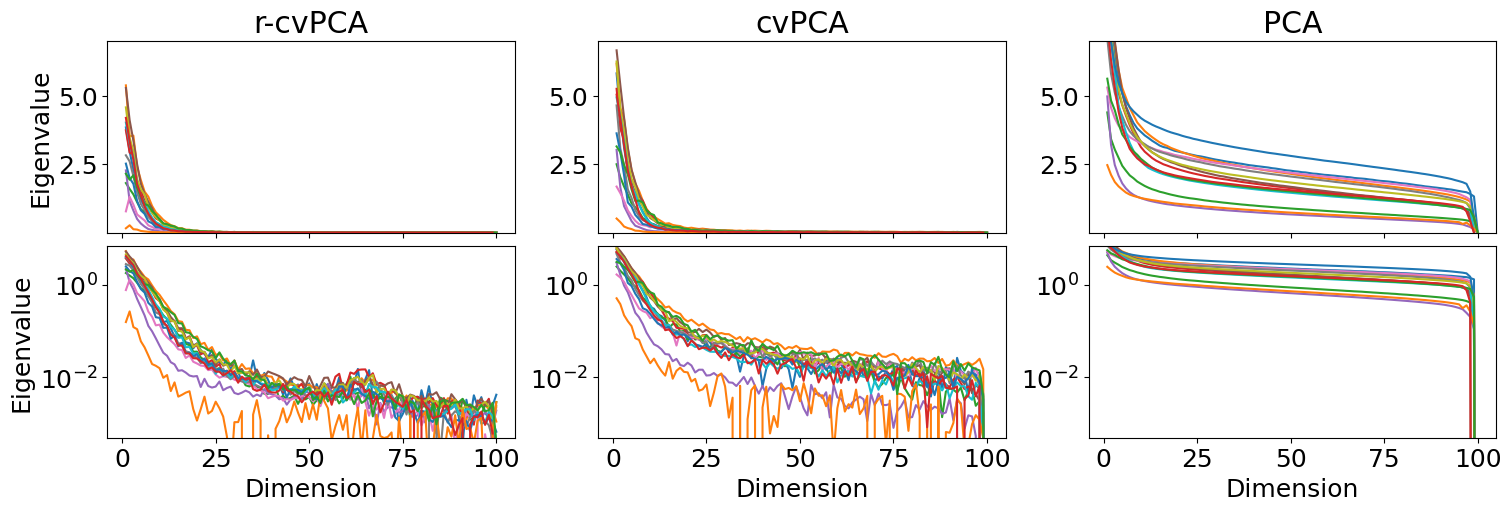

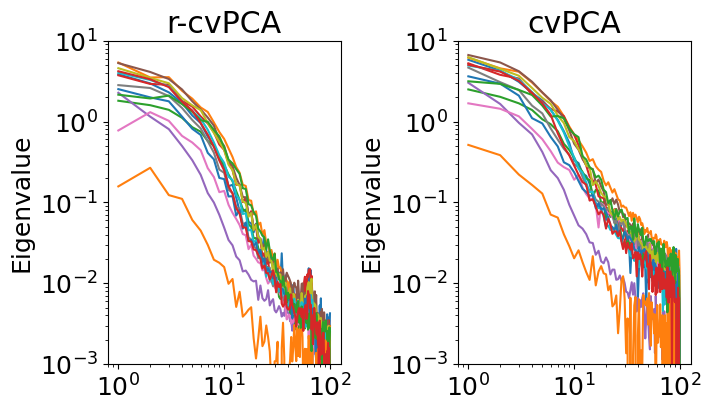

In [37]:
xscale = "linear"
yscale = "linear"

isvd = 1
idims = np.arange(num_bins) + 1
plt.close('all')
fig, ax = plt.subplots(2, 3, figsize=(15, 5), layout="constrained", sharex=True)
ax[0, 0].plot(idims, avg_reg_covariances[isvd].T)
ax[0, 1].plot(idims, avg_org_covariances[isvd].T)
ax[0, 2].plot(idims, avg_pca_covariances[isvd].T)
ax[1, 0].plot(idims, avg_reg_covariances[isvd].T)
ax[1, 1].plot(idims, avg_org_covariances[isvd].T)
ax[1, 2].plot(idims, avg_pca_covariances[isvd].T)
ax[0, 0].set_title("r-cvPCA")
ax[0, 1].set_title("cvPCA")
ax[0, 2].set_title("PCA")
ax[0, 0].set_xscale("linear")
ax[0, 1].set_xscale("linear")
ax[0, 2].set_xscale("linear")
ax[0, 0].set_yscale("linear")
ax[0, 1].set_yscale("linear")
ax[0, 2].set_yscale("linear")
ax[1, 0].set_xscale("linear")
ax[1, 1].set_xscale("linear")
ax[1, 2].set_xscale("linear")
ax[1, 0].set_yscale("log")
ax[1, 1].set_yscale("log")
ax[1, 2].set_yscale("log")
ax[1, 0].set_xlabel("Dimension")
ax[1, 1].set_xlabel("Dimension")
ax[1, 2].set_xlabel("Dimension")
ax[0, 0].set_ylabel("Eigenvalue")
ax[1, 0].set_ylabel("Eigenvalue")
ax[0, 0].set_ylim(5e-4, 7e0)
ax[0, 1].set_ylim(5e-4, 7e0)
ax[0, 2].set_ylim(5e-4, 7e0)
ax[1, 0].set_ylim(5e-4, 7e0)
ax[1, 1].set_ylim(5e-4, 7e0)
ax[1, 2].set_ylim(5e-4, 7e0)
plt.show()

idims = np.arange(num_bins) + 1
plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(7, 4), layout="constrained", sharex=True)
ax[0].plot(idims, avg_reg_covariances[isvd].T)
ax[1].plot(idims, avg_org_covariances[isvd].T)
ax[0].set_title("r-cvPCA")
ax[1].set_title("cvPCA")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_ylabel("Eigenvalue")
ax[1].set_ylabel("Eigenvalue")
ax[0].set_ylim(1e-3, 1e1)
ax[1].set_ylim(1e-3, 1e1)
plt.show()

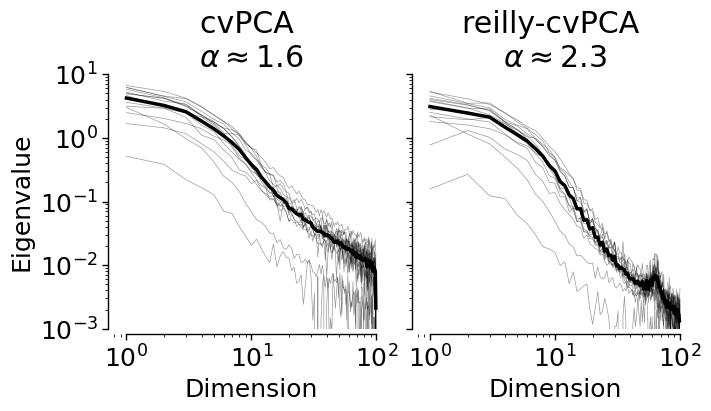

In [95]:
idims = np.arange(num_bins) + 1

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(7, 4), layout="constrained", sharex=True, sharey=True)
ax[0].plot(idims, avg_org_covariances[isvd].T, color="k", alpha=0.4, linewidth=0.5)
ax[1].plot(idims, avg_reg_covariances[isvd].T, color="k", alpha=0.4, linewidth=0.5)
ax[0].plot(idims, np.mean(avg_org_covariances[isvd], axis=0), color="k", linewidth=2.5)
ax[1].plot(idims, np.mean(avg_reg_covariances[isvd], axis=0), color="k", linewidth=2.5)
ax[0].set_title("cvPCA \n" + r"$\alpha \approx 1.6$")
ax[1].set_title("reilly-cvPCA \n" + r"$\alpha \approx 2.3$")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].set_xlabel("Dimension")
ax[1].set_xlabel("Dimension")
ax[0].set_ylabel("Eigenvalue")
# ax[1].set_ylabel("Eigenvalue")
ax[0].set_ylim(1e-3, 1e1)
ax[1].set_ylim(1e-3, 1e1)
format_spines(
    ax[0],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(idims[0], idims[-1]),
    ybounds=(1e-3, 1e1),
)
format_spines(
    ax[1],
    x_pos=-0.02,
    y_pos=-0.02,
    xbounds=(idims[0], idims[-1]),
    ybounds=(1e-3, 1e1),
)

figure_path = registry.registry_paths.figure_path / "cvpca" / f"compare_cvPCA_rcvPCA"
save_figure(fig, figure_path)
plt.show()

In [86]:
from scipy.optimize import curve_fit

x_offset = 7
x_last = 50
exp_func_log = lambda x, A, M: np.log(A) - x / M
nrm_func_log = lambda x, A, M: np.log(A) - x**2 / (2 * M**2)
pow_func_log = lambda x, A, M: np.log(A) - M * np.log(x)

funcs = [exp_func_log, nrm_func_log, pow_func_log]
num_funcs = len(funcs)
def get_fits(covariances: np.ndarray):
    amplitude = np.full((covariances.shape[0], num_funcs), np.nan)
    shape = np.full((covariances.shape[0], num_funcs), np.nan)
    mse = np.full((covariances.shape[0], num_funcs), np.nan)
    pr = np.full((covariances.shape[0], ), np.nan)
    for icurve in range(covariances.shape[0]):
        mask = ~np.isnan(covariances[icurve]) & (covariances[icurve] > 0) & (np.arange(num_bins) >= x_offset) & (np.arange(num_bins) <= x_last)
        if np.sum(mask) == 0:
            continue
        ydata = covariances[icurve, mask]
        ydata = ydata / np.nansum(covariances[icurve])
        xdata_fit = np.arange(num_bins)[mask]
        pr[icurve] = np.sum(ydata)**2 / np.sum(ydata**2)
        for ifunc, func in enumerate(funcs):
            try:
                popt, _ = curve_fit(func, xdata_fit, np.log(ydata), p0=[1.0, 5.0])
                amplitude[icurve, ifunc] = np.exp(popt[0])
                shape[icurve, ifunc] = popt[1]
                mse[icurve, ifunc] = np.mean((func(xdata_fit, *popt) - ydata)**2)
            except RuntimeError:
                continue

    results = dict(
        amplitude=amplitude,
        shape=shape,
        mse=mse,
        pr=pr
    )
    return results

def avg_by_mouse(result, mouse_names):
    mice = list(set(mouse_names))
    mouse_names = np.array(mouse_names)
    avg_result = {key: np.full((len(mice), num_funcs), np.nan) for key in result.keys()}
    for imouse, mouse in enumerate(mice):
        if np.sum(mouse_names == mouse) == 0:
            print(f"No sessions for {mouse}")
            continue
        for key, value in result.items():
            avg_result[key][imouse] = np.nanmean(value[mouse_names == mouse], axis=0)
    return avg_result

isvd = 1
idx_use = [0, 1]
names = ["r-cvPCA", "cvPCA", "smooth cvPCA", "PCA", "smooth PCA"]
covs = [reg_covariances[isvd], org_covariances[isvd], org_smooth_covariances[isvd], pca_covariances[isvd], pca_smooth_covariances[isvd]]
results = [get_fits(cov) for cov in covs]
avg_results = [avg_by_mouse(result, mouse_names) for result in results]

C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\2355150708.py:5: RuntimeWarning: invalid value encountered in log
  exp_func_log = lambda x, A, M: np.log(A) - x / M
C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\2355150708.py:6: RuntimeWarning: invalid value encountered in log
  nrm_func_log = lambda x, A, M: np.log(A) - x**2 / (2 * M**2)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\2355150708.py:7: RuntimeWarning: invalid value encountered in log
  pow_func_log = lambda x, A, M: np.log(A) - M * np.log(x)
C:\Users\Andrew\AppData\Local\Temp\ipykernel_29284\2355150708.py:27: RuntimeWarning: overflow encountered in exp
  amplitude[icurve, ifunc] = np.exp(popt[0])


In [87]:
use_names = [names[i] for i in idx_use]
use_avg_results = [avg_results[i] for i in idx_use]

In [93]:
use_avg_results[0]["shape"][:, 2].mean()

2.3302622989054913

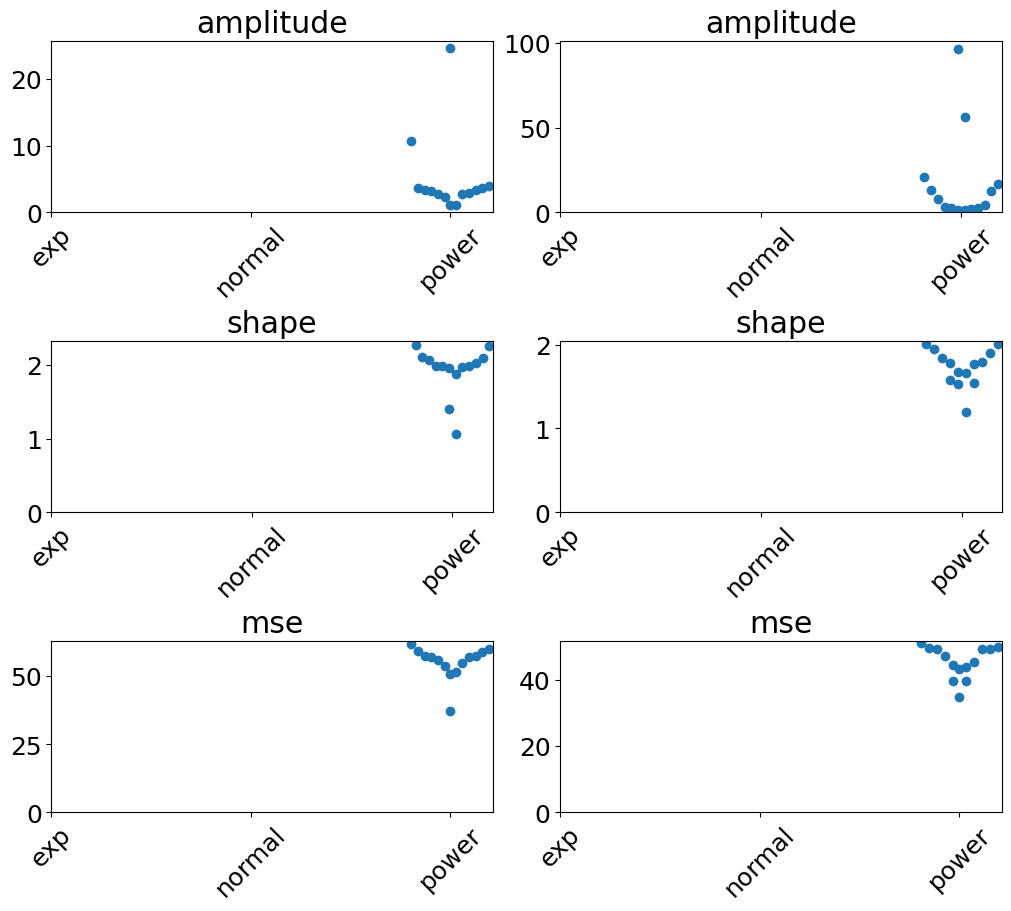

In [ ]:
from vrAnalysis.helpers import beeswarm

func_names = ["exp", "normal", "power"]
show_keys = ["amplitude", "shape", "mse"]

beewidth = 0.2
keys = list(avg_results[0].keys())
num_keys = len(keys)
fig, ax = plt.subplots(3, 2, figsize=(10, 9), layout="constrained")
for ii in range(2):
    for jj in range(3):
        data = use_avg_results[ii][show_keys[jj]]
        for imodel in [2]: #range(3):
            ax[jj, ii].plot(imodel + beewidth * beeswarm(data[:, imodel]), data[:, imodel], label=func_names[imodel], marker="o", linestyle="None")
        ax[jj, ii].set_title(show_keys[jj])
        ax[jj, ii].set_ylim(0)
        ax[jj, ii].set_xticks(np.arange(len(func_names)), labels=func_names, rotation=45)

plt.show()